<a href="https://colab.research.google.com/github/githubramaadiga/Titash/blob/master/Copy_of_SequenceAnalytics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install biopython
!pip install pqdm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 5.6 MB/s eta 0:00:00


In [ ]:
!wget https://raw.githubusercontent.com/arnavdas88/protein-epitope-analytics/main/uniprot.fasta?token=AJINPMMP2ERHQDUMQXSXFGDBVZZLQ -O uniprot.fasta

--2024-01-28 02:27:33--  https://raw.githubusercontent.com/arnavdas88/protein-epitope-analytics/main/uniprot.fasta?token=AJINPMMP2ERHQDUMQXSXFGDBVZZLQ
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 21935788 (21M) [text/plain]
Saving to: ‘uniprot.fasta’

uniprot.fasta       100%[===================>]  20.92M  53.0MB/s    in 0.4s    

2024-01-28 02:27:36 (53.0 MB/s) - ‘uniprot.fasta’ saved [21935788/21935788]



In [ ]:
from Bio import SeqIO
from tqdm import tqdm
# from pqdm.processes import pqdm
# from pqdm.threads import pqdm
import time

import multiprocessing as mp

In [ ]:
string = ""

type_str = {}

def get_type(desc):
    d = desc.upper()
    d = "DENGUE" + d.split("DENGUE")[-1]


    d = d.split(" OX=")[0]
    d = d.split(" (")[0]
    d = d.replace("TYPE ", "")
    return d

for record in SeqIO.parse("uniprot.fasta", "fasta"):
    fragment_id = record.id
    name = record.name
    description = record.description
    seq = record.seq
    # print(get_type(description))
    # input()

    type_str[get_type(description)] = str(seq) + type_str.get(get_type(description), "")

    string += str(seq)

In [ ]:
type_str.keys()

dict_keys(['DENGUE VIRUS 2', 'DENGUE VIRUS 4', 'DENGUE VIRUS 1', 'DENGUE VIRUS 3', 'DENGUE VIRUS'])

In [ ]:
len(string)

20579995

In [ ]:
chunk_size = 10

In [ ]:
def find_repeation(string, chunk_size):
    repeated_sequence = {}
    pure_sequence = []

    for i in tqdm(range(0, len(string) - chunk_size)):
        chunk = string[i:i+chunk_size]
        if chunk in string[i+chunk_size:] or chunk in repeated_sequence:
            repeated_sequence[chunk] = repeated_sequence.get(chunk, 0) + 1
        else:
            pure_sequence += [ chunk ]

    return repeated_sequence, pure_sequence

In [ ]:
def worker_wrapper(*arg):
    string, chunk_size = arg
    print(string, chunk_size)
    return find_repeation(string, chunk_size)

def find_parallel_repeation(string, chunk_size, N=None):
    string_leb = [string[i:i+N] for i in range(0, len(string), N)]

    assert sum([len(s) for s in string_leb]) == len(string)

    pool = mp.Pool(mp.cpu_count())
    args_list = [ (s, chunk_size) for s in string_leb]
    # results = [pool.apply(worker_wrapper, args=args) for args in args_list]
    # pool.close()
    pool.map(worker_wrapper, args_list)

    return result


# parallel = int(len(string) / 100) # string_leb
# result = find_parallel_repeation(string, chunk_size,  parallel)

In [ ]:
# (repeated_sequence, pure_sequence) = find_repeation(
#     string[
#            0:                       # The first
#            int(len(string)/20)      # 5% of the total data
#         ],
#     10)                     # Chunk Size: 10

In [ ]:
# f'The most common sequence in the first 1% of the dataset is being repeated {max(repeated_sequence.values())} times.'

In [ ]:
# sorted_by_repetation = dict(sorted(repeated_sequence.items(), key=lambda item: item[1])[-100:])

In [ ]:
# sorted_by_repetation

In [ ]:
def merge(dictA, dictB):
    for key, value in dictA.items():
        if key in dictB:
            dictB[key] += value
        else:
            dictB[key] = value
    return dictB.copy()

In [ ]:
from multiprocessing import Pool

def total_data(chunk = 20):

    batches = [i for i in range(0, 101, 5)]

    args = []

    for i in range(len(batches) - 1):
        start = batches[i]
        end   = batches[i+1]

        start = int(len(string) * (start / 100))
        end = int(len(string) * (end / 100))

        args += [ (string[start:end], chunk) ]

    pool = Pool()
    data = pool.starmap(find_repeation, args)

    all_repeated_sequence = {}

    print("Merging the sequences...")

    for n in range(len(batches) - 1):
        (repeated_sequence, _) = data[n]
        all_repeated_sequence = merge(all_repeated_sequence, repeated_sequence)
        del repeated_sequence

    return all_repeated_sequence

In [ ]:
repeated_sequence = total_data(chunk = 10)

100%|██████████| 1028990/1028990 [00:46<00:00, 22082.87it/s] 


Merging the sequences...


In [ ]:
f'The most common sequence being repeated {max(repeated_sequence.values())} times.'

'The most common sequence being repeated 37433 times.'

In [ ]:
final_dict = []

for seq, rep in repeated_sequence.items():
    row = {}
    row['Sequence'] = seq
    row['Repeation'] = rep
    seen_in = []
    seen_in = [ variant for variant, data in type_str.items() if seq in data ]
    row['Seen In'] = ", ".join(seen_in)

    final_dict += [ row ]

In [ ]:
import pandas as pd

df = pd.DataFrame.from_dict(final_dict)

df.head()

,Sequence,Repeation,Seen In
0,LRMDKLQLKG,2050,"DENGUE VIRUS 2, DENGUE VIRUS 1, DENGUE VIRUS"
1,RMDKLQLKGM,2047,"DENGUE VIRUS 2, DENGUE VIRUS 1, DENGUE VIRUS"
2,MDKLQLKGMS,2049,"DENGUE VIRUS 2, DENGUE VIRUS 1, DENGUE VIRUS"
3,DKLQLKGMSY,2053,"DENGUE VIRUS 2, DENGUE VIRUS 1, DENGUE VIRUS"
4,KLQLKGMSYS,2042,"DENGUE VIRUS 2, DENGUE VIRUS 1, DENGUE VIRUS"


In [ ]:
df.describe()

,Repeation
count,49780.000000
mean,407.753114
std,854.055919
min,2.000000
25%,2.000000
50%,14.000000
75%,381.000000
max,37433.000000


In [ ]:
# Filter
filtered_df = df[
                 df["Seen In"].str.contains("DENGUE VIRUS 4") &
                 df["Seen In"].str.contains("DENGUE VIRUS 3") &
                 df["Seen In"].str.contains("DENGUE VIRUS 2") &
                 df["Seen In"].str.contains("DENGUE VIRUS 1")
            ]

filtered_df.head()

,Sequence,Repeation,Seen In
124,RMAILGDTAW,6008,"DENGUE VIRUS 2, DENGUE VIRUS 4, DENGUE VIRUS 1..."
125,MAILGDTAWD,6025,"DENGUE VIRUS 2, DENGUE VIRUS 4, DENGUE VIRUS 1..."
126,AILGDTAWDF,6031,"DENGUE VIRUS 2, DENGUE VIRUS 4, DENGUE VIRUS 1..."
127,ILGDTAWDFG,6063,"DENGUE VIRUS 2, DENGUE VIRUS 4, DENGUE VIRUS 1..."
128,LGDTAWDFGS,6077,"DENGUE VIRUS 2, DENGUE VIRUS 4, DENGUE VIRUS 1..."


In [ ]:
filtered_df.describe()

,Repeation
count,698.000000
mean,3110.882521
std,2244.150480
min,2.000000
25%,1571.500000
50%,3259.000000
75%,4512.750000
max,37433.000000


In [ ]:
df.to_csv("100% seq chunk-10.csv", index=False, )
filtered_df.to_csv("[filtered]100% seq chunk-10.csv", index=False, )
df.shape

# df = pd.read_csv("100% seq chunk-10.csv",)
# filtered_df = pd.read_csv("[filtered]100% seq chunk-10.csv",  )

(49780, 3)

In [ ]:
!wget https://raw.githubusercontent.com/zikunyang/DCVST/master/NegativeB.txt
!wget https://raw.githubusercontent.com/zikunyang/DCVST/master/NegativeT.txt
!wget https://raw.githubusercontent.com/zikunyang/DCVST/master/PositiveB.txt
!wget https://raw.githubusercontent.com/zikunyang/DCVST/master/PositiveT.txt
!wget https://raw.githubusercontent.com/zikunyang/DCVST/fbceb6dbb9f738b59e3ec05598853475d8aafd7c/Antigen.txt


--2024-01-28 02:13:30--  https://raw.githubusercontent.com/zikunyang/DCVST/master/NegativeB.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 54175 (53K) [text/plain]
Saving to: ‘NegativeB.txt’

NegativeB.txt       100%[===================>]  52.91K  --.-KB/s    in 0.01s   

2024-01-28 02:13:30 (4.56 MB/s) - ‘NegativeB.txt’ saved [54175/54175]

--2024-01-28 02:13:30--  https://raw.githubusercontent.com/zikunyang/DCVST/master/NegativeT.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 61467 (60K) [text/plain]
Saving to: ‘Negati

In [ ]:
for key, description in Z_descriptor.items(): assert len(description) ==3

In [ ]:
dataset_test = ReadTxtName (r'./PositiveB.txt')
dataset_test = encode(dataset_test)

## Machine Learning

import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import torch
import math
from tqdm import tqdm
import numpy as np
from time import time
import torch.distributions as tdis
import matplotlib.pyplot as plt
from torch import nn
from torch import optim
from torch.utils.data import TensorDataset, RandomSampler, BatchSampler, DataLoader
sns.set_style('dark')

In [ ]:
# helper
def ReadTxtName(rootdir):                        ##FASTA Reader
    lines = []
    with open(rootdir, 'r') as file_to_read:
        while True:
            line = file_to_read.readline()
            if not line:
                break
            line = line.strip('\n')
            lines.append(line)
    return lines

#### Z-descriptor and ACC transformation for protein annotation

In [ ]:
Z_descriptor = {
    'A': (0.07, -1.73, 0.09),
    'V': (-2.69, -2.53, -1.29),
    'L': (-4.19, - 1.03, -0.98),
    'I': (-4.44, -1.68, -1.03),
    'P': (-1.22, 0.88, 2.23),
    'F': (-4.92, 1.30, 0.45),
    'W': (-4.75, 3.65, 0.85),
    'M': (-2.49, -0.27, -0.41),
    'K': (2.84, 1.41, -3.14),
    "R": ( 2.88, 2.52, -3.44),
    "H": ( 2.41, 1.74,  1.11),
    "G": ( 2.23,-5.36,  0.30),
    "S": ( 1.96,-1.63,  0.57),
    "T": ( 0.92,-2.09, -1.40),
    "C": ( 0.71,-0.97,  4.13),
    "Y": (-1.39, 2.32,  0.01),
    "N": ( 3.22, 1.45,  0.84),
    "Q": ( 2.18, 0.53, -1.14),
    "D": ( 3.64, 1.13,  2.36),
    "E": ( 3.08, 0.39, -0.07),
    "X": ( 0.00, 0.00, 0.00),
    "Z": ( 0.00, 0.00, 0.00)
}
# Z_descriptor = list(Z_descriptor.keys())
# Z_descriptor = { Z_descriptor[i]: [i] for i in range(len(Z_descriptor))  }
def Z(antigen):
    return list(Z_descriptor[antigen.upper()])

def unZ(descriptor):
    epit = ""
    for i in descriptor:
        epit += "".join([ag for ag, z in Z_descriptor.items() if list(z) == list(i)])
    return epit


def encode (dataset):
    dataset_length = len(dataset)
    new_dataset = []
    for i in range(dataset_length):
        seq = dataset[i].upper()
        try:
            description = [ Z(prot) for prot in seq ]
            new_dataset += [ description ]
        except:
            print(seq)
    return new_dataset



In [ ]:
def ACC (dataset):

    ACCN = [0] * len(dataset)
    for i in range (len(ACCN)):
        ACCN[i] = [0] * 46 ## 45 variables for ACC and 1 for whether it's BPAs

    for i in range (len(dataset)):
        description = [0] * len(dataset[i])
        for k in range(len(dataset[i])):
            description[k] = Z(dataset[i][k])


        ##l=1
        ##Calculate AJJ:
        l   = 1
        n   = len(dataset[i])
        cal = 0
        for j in range (n-l):
            cal = cal + (description[j][0] * description[j+1][0] / (n-l))
        ACCN[i][0] = cal
        cal = 0
        for j in range (n-l):
            cal = cal + (description[j][1] * description[j+1][1] / (n-l))
        ACCN[i][1] = cal
        cal = 0
        for j in range (n-l):
            cal = cal + (description[j][2] * description[j+1][2] / (n-l))
        ACCN[i][2] = cal

        ##Calculate CJK:
        cal = 0
        for j in range (n-l):
            cal = cal + (description[j][0] * description[j+1][1] / (n-l))
        ACCN[i][3] = cal
        cal = 0
        for j in range (n-l):
            cal = cal + (description[j][0] * description[j+1][2] / (n-l))
        ACCN[i][4] = cal
        for j in range (n-l):
            cal = cal + (description[j][1] * description[j+1][0] / (n-l))
        ACCN[i][5] = cal
        for j in range (n-l):
            cal = cal + (description[j][1] * description[j+1][2] / (n-l))
        ACCN[i][6] = cal
        for j in range (n-l):
            cal = cal + (description[j][2] * description[j+1][0] / (n-l))
        ACCN[i][7] = cal
        for j in range (n-l):
            cal = cal + (description[j][2] * description[j+1][1] / (n-l))
        ACCN[i][8] = cal

        ##l=2
        ##Calculate AJJ:
        l   = 2
        n   = len(dataset[i])
        cal = 0
        for j in range (n-l):
            cal = cal + (description[j][0] * description[j+1][0] / (n-l))
        ACCN[i][9] = cal
        cal = 0
        for j in range (n-l):
            cal = cal + (description[j][1] * description[j+1][1] / (n-l))
        ACCN[i][10] = cal
        cal = 0
        for j in range (n-l):
            cal = cal + (description[j][2] * description[j+1][2] / (n-l))
        ACCN[i][11] = cal

        ##Calculate CJK:
        cal = 0
        for j in range (n-l):
            cal = cal + (description[j][0] * description[j+1][1] / (n-l))
        ACCN[i][12] = cal
        cal = 0
        for j in range (n-l):
            cal = cal + (description[j][0] * description[j+1][2] / (n-l))
        ACCN[i][13] = cal
        for j in range (n-l):
            cal = cal + (description[j][1] * description[j+1][0] / (n-l))
        ACCN[i][14] = cal
        for j in range (n-l):
            cal = cal + (description[j][1] * description[j+1][2] / (n-l))
        ACCN[i][15] = cal
        for j in range (n-l):
            cal = cal + (description[j][2] * description[j+1][0] / (n-l))
        ACCN[i][16] = cal
        for j in range (n-l):
            cal = cal + (description[j][2] * description[j+1][1] / (n-l))
        ACCN[i][17] = cal

        ##l=3
        ##Calculate AJJ:
        l   = 3
        n   = len(dataset[i])
        cal = 0
        for j in range (n-l):
            cal = cal + (description[j][0] * description[j+1][0] / (n-l))
        ACCN[i][18] = cal
        cal = 0
        for j in range (n-l):
            cal = cal + (description[j][1] * description[j+1][1] / (n-l))
        ACCN[i][19] = cal
        cal = 0
        for j in range (n-l):
            cal = cal + (description[j][2] * description[j+1][2] / (n-l))
        ACCN[i][20] = cal

        ##Calculate CJK:
        cal = 0
        for j in range (n-l):
            cal = cal + (description[j][0] * description[j+1][1] / (n-l))
        ACCN[i][21] = cal
        cal = 0
        for j in range (n-l):
            cal = cal + (description[j][0] * description[j+1][2] / (n-l))
        ACCN[i][22] = cal
        for j in range (n-l):
            cal = cal + (description[j][1] * description[j+1][0] / (n-l))
        ACCN[i][23] = cal
        for j in range (n-l):
            cal = cal + (description[j][1] * description[j+1][2] / (n-l))
        ACCN[i][24] = cal
        for j in range (n-l):
            cal = cal + (description[j][2] * description[j+1][0] / (n-l))
        ACCN[i][25] = cal
        for j in range (n-l):
            cal = cal + (description[j][2] * description[j+1][1] / (n-l))
        ACCN[i][26] = cal

        ##l=4
        ##Calculate AJJ:
        l   = 4
        n   = len(dataset[i])
        cal = 0
        for j in range (n-l):
            cal = cal + (description[j][0] * description[j+1][0] / (n-l))
        ACCN[i][27] = cal
        cal = 0
        for j in range (n-l):
            cal = cal + (description[j][1] * description[j+1][1] / (n-l))
        ACCN[i][28] = cal
        cal = 0
        for j in range (n-l):
            cal = cal + (description[j][2] * description[j+1][2] / (n-l))
        ACCN[i][29] = cal

        ##Calculate CJK:
        cal = 0
        for j in range (n-l):
            cal = cal + (description[j][0] * description[j+1][1] / (n-l))
        ACCN[i][30] = cal
        cal = 0
        for j in range (n-l):
            cal = cal + (description[j][0] * description[j+1][2] / (n-l))
        ACCN[i][31] = cal
        for j in range (n-l):
            cal = cal + (description[j][1] * description[j+1][0] / (n-l))
        ACCN[i][32] = cal
        for j in range (n-l):
            cal = cal + (description[j][1] * description[j+1][2] / (n-l))
        ACCN[i][33] = cal
        for j in range (n-l):
            cal = cal + (description[j][2] * description[j+1][0] / (n-l))
        ACCN[i][34] = cal
        for j in range (n-l):
            cal = cal + (description[j][2] * description[j+1][1] / (n-l))
        ACCN[i][35] = cal

        ##l=5
        ##Calculate AJJ:
        l   = 5
        n   = len(dataset[i])
        cal = 0
        for j in range (n-l):
            cal = cal + (description[j][0] * description[j+1][0] / (n-l))
        ACCN[i][36] = cal
        cal = 0
        for j in range (n-l):
            cal = cal + (description[j][1] * description[j+1][1] / (n-l))
        ACCN[i][37] = cal
        cal = 0
        for j in range (n-l):
            cal = cal + (description[j][2] * description[j+1][2] / (n-l))
        ACCN[i][38] = cal

        ##Calculate CJK:
        cal = 0
        for j in range (n-l):
            cal = cal + (description[j][0] * description[j+1][1] / (n-l))
        ACCN[i][39] = cal
        cal = 0
        for j in range (n-l):
            cal = cal + (description[j][0] * description[j+1][2] / (n-l))
        ACCN[i][40] = cal
        for j in range (n-l):
            cal = cal + (description[j][1] * description[j+1][0] / (n-l))
        ACCN[i][41] = cal
        for j in range (n-l):
            cal = cal + (description[j][1] * description[j+1][2] / (n-l))
        ACCN[i][42] = cal
        for j in range (n-l):
            cal = cal + (description[j][2] * description[j+1][0] / (n-l))
        ACCN[i][43] = cal
        for j in range (n-l):
            cal = cal + (description[j][2] * description[j+1][1] / (n-l))
        ACCN[i][44] = cal

    return ACCN

In [ ]:
for key, description in Z_descriptor.items():
    assert len(description) == 3

In [ ]:
## Read the dataset
dataset_test  = ReadTxtName(r'./PositiveY.txt')

## Protein annotation:
dataset_test = encode(dataset_test)

dataset_test[0]

[[-4.92, 1.3, 0.45],
 [2.23, -5.36, 0.3],
 [2.18, 0.53, -1.14],
 [2.18, 0.53, -1.14],
 [2.88, 2.52, -3.44],
 [0.0, 0.0, 0.0],
 [-4.92, 1.3, 0.45],
 [2.84, 1.41, -3.14],
 [3.08, 0.39, -0.07],
 [2.84, 1.41, -3.14]]

In [ ]:
dataset_test  = ReadTxtName('PositiveY.txt')

## Protein annotation:dataset_test = encode(dataset_test)

dataset_test[0]


'FGQQRXFKEK'

In [ ]:
## Read the dataset
#dataset_test  = ReadTxtName(r'./PositiveB.txt')
dataset_test  = ReadTxtName('FilteredB.txt')
## Protein annotation:
dataset_test = encode(dataset_test)

dataset_test[0]

[[2.88, 2.52, -3.44],
 [-2.49, -0.27, -0.41],
 [0.07, -1.73, 0.09],
 [-4.44, -1.68, -1.03],
 [-4.19, -1.03, -0.98],
 [2.23, -5.36, 0.3],
 [3.64, 1.13, 2.36],
 [0.92, -2.09, -1.4],
 [0.07, -1.73, 0.09],
 [-4.75, 3.65, 0.85]]

added text for positive L .text

#### Model PRO-I-GEN


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, TensorDataset
from torch.utils.data import DataLoader
#import models as models
# pip install tqdm

In [ ]:
class Lambda(nn.Module):
    def __init__(self, func):
        super().__init__()
        self.func = func

    def forward(self, x):
        return self.func(x)


def preprocess(x):
    return x.view(-1, 1, 45, 1)



def Antigens(antigens, num_epochs=9000, batch_size=128, model=None, lrate=0.001):

    counter   = antigens.shape[1] - 1
    X         = antigens[:,:counter]        # Protein ACC
    Y         = antigens[:,45:]             # Whether it's BPA


    if not model:
        model = nn.Sequential(                         # Deep Neural Network
                    Lambda(preprocess),
                    nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
                    nn.ReLU(),
                    nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1),
                    nn.ReLU(),
                    nn.Conv2d(16, 1, kernel_size=3, stride=2, padding=1),
                    nn.ReLU(),
                    nn.AvgPool2d((6, 1)),
                    Lambda(lambda x: x.view(x.size(0), -1)),
                )

    opt   = optim.Adam(model.parameters(), lr=lrate)
    td    = TensorDataset(X, Y)
    epoch = 0
    best_loss = 1.0
    best_state = None
    loss = None
    history = []



    model.train()
    while epoch < num_epochs:
        data = [ [x, y] for (x, y) in DataLoader(td, batch_size, shuffle=True, drop_last=True) ]
        for x, y in tqdm(data, desc=f"Epoch {epoch}"):
            opt.zero_grad()
            result = model(x)
            # print(x.shape, y.shape, result.shape)
            loss   = ((result - y)**2).mean() # MSE Loss
            #loss   = nn.CrossEntropyLoss(result, y).mean()
            #loss   = torch.mean(torch.clamp(1 - result.t() * y, min=0))  # hinge loss
            #loss  += 0.01 * torch.mean(model.weight ** 2)  # l2 penalty
            loss.backward()
            opt.step()

            if loss < best_loss:
                best_loss = loss
                best_state = model.state_dict()

        epoch += 1

        # print(loss.item() if loss else "")
        if loss:
            history += [loss]
    model.load_state_dict(best_state)
    return model, history




#### Train for Antigen

In [ ]:
## Read the dataset
datasetA_p  = ReadTxtName(r'./PositiveB.txt')
datasetA_n  = ReadTxtName(r'./NegativeB.txt')

## Protein annotation:
datasetA_n = ACC(datasetA_n)
datasetA_p = ACC(datasetA_p)
for i in range (len(datasetA_p)):
    datasetA_p[i][45] = 1

target = [*datasetA_n, *datasetA_p]

In [ ]:
## Read the dataset
datasetA_p  = ReadTxtName('FilteredB.txt')
datasetA_n  = ReadTxtName(r'./NegativeB.txt')

## Protein annotation:
datasetA_n = ACC(datasetA_n)
datasetA_p = ACC(datasetA_p)
for i in range (len(datasetA_p)):
    datasetA_p[i][45] = 1

target = [*datasetA_n, *datasetA_p]

duplicated the code for PositiveL

In [ ]:
antigens = torch.tensor(target)
counter   = antigens.shape[1] - 1
X         = antigens[:,:counter]        # Protein ACC
Y         = antigens[:,45:]             # Whether it's BPA

X.shape, Y.shape



(torch.Size([5610, 45]), torch.Size([5610, 1]))

In [ ]:
Amodel, training_history = Antigens(torch.tensor(antigens), num_epochs = 100)

<ipython-input-208-690fef1b0073>:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Amodel, training_history = Antigens(torch.tensor(antigens), num_epochs = 100)
Epoch 99: 100%|██████████| 43/43 [00:00<00:00, 124.98it/s]


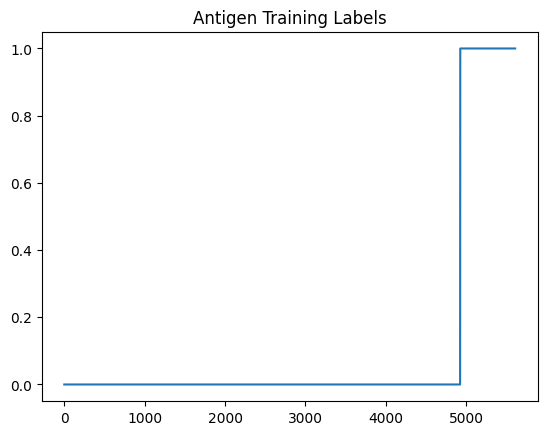

In [ ]:
import matplotlib.pyplot as plt
plt.plot(Y.numpy())
plt.title("Antigen Training Labels")
plt.show()

RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.

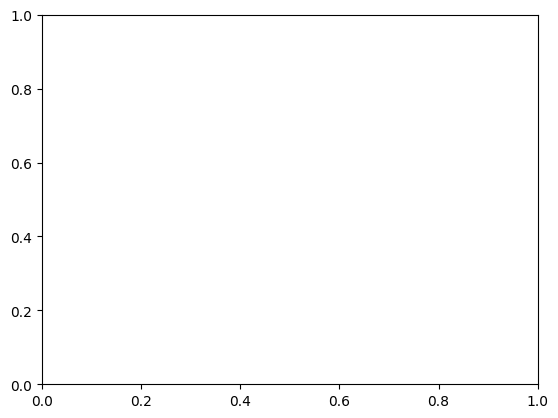

In [ ]:
plt.plot(training_history)
plt.title("Antigen Training Loss")
plt.show()

NameError: name 'history' is not defined

In [ ]:
filtered_df = pd.read_csv("[filtered]100% seq chunk-10.csv",  )

In [ ]:
filtered_dataset_X = ACC(filtered_df['Sequence'].values)
antigens = torch.tensor(filtered_dataset_X)

counter   = antigens.shape[1] - 1
X         = antigens[:,:counter]        # Protein ACC
Y         = antigens[:,45:]             # Whether it's BPA

#antigens.shape
Amodel.eval()
Y_pred = Amodel(X)
Y_pred_bin = (Y_pred > 0.6).int()

X.shape, Y_pred.shape



(torch.Size([698, 45]), torch.Size([698, 1]))

Ignore the 0s, 1 is Antigen Candidate


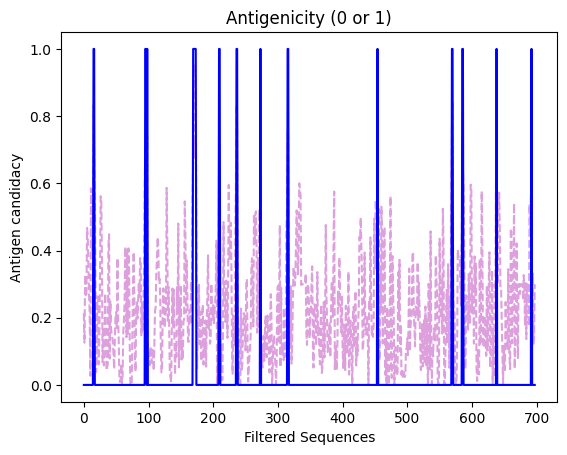

In [ ]:
print("Ignore the 0s, 1 is Antigen Candidate")

Y_pred = Y_pred.detach().numpy()
Y_pred_bin = Y_pred_bin.detach().numpy()

plt.plot(Y_pred, '--', color="plum")
plt.plot(Y_pred_bin, color="blue")
plt.title("Antigenicity (0 or 1)")
plt.xlabel('Filtered Sequences')
plt.ylabel('Antigen candidacy')
plt.show()

In [ ]:
sequence_r = X[19]
sequence_r

tensor([-1.9066, -1.3528, -0.2916, -0.1630, -0.6482, -2.2513, -2.5737, -3.7339,
        -3.2947, -2.9703, -2.5804, -0.3291,  0.4509, -0.5815, -1.0075, -1.6167,
        -2.9160, -2.4264, -2.9518, -1.1726, -0.3766, -0.2238, -0.6678, -2.2190,
        -2.9076, -4.3329, -3.8728, -2.5183, -1.6092, -0.4188, -2.4855, -0.6546,
        -2.3639, -3.1538, -4.6643, -4.4938, -1.2092, -1.8700, -0.3091, -2.7861,
        -0.4870, -1.9755, -2.8307, -3.4680, -3.1359])

In [ ]:
# Amodel

In [ ]:
# attention_layer = 6
# input = torch.tensor( sequence_r )
# fig, ax = plt.subplots(figsize = (16, 2))

# for layer_num in range(attention_layer):
#     layer = Amodel[layer_num]
#     input = layer(input)

# data = input.detach().numpy().reshape(input.shape[-2:])
# data = input @ torch.tensor( [ np.array(sequence_r) ] )
# data = data.reshape( data.shape[-2:] )
# data = data.detach().numpy()

# # Smoothing
# from scipy.ndimage.filters import gaussian_filter
# data_smooth = gaussian_filter(data, sigma=1)


# # Plot
# ax = sns.heatmap(data_smooth)
# ax.set_xlabel('Reduced Input Sequence')
# ax.set_ylabel('Model (6 Nodes)')

# plt.title("Correlation matrix between Reduced-Input and Model")
# plt.show()

### Custom Model

In [ ]:
import tensorflow as tf

In [ ]:
# class BahdanauAttention(tf.keras.layers.Layer):
#   def __init__(self, units):
#     super().__init__()
#     # For Eqn. (4), the  Bahdanau attention
#     self.W1 = tf.keras.layers.Dense(units, use_bias=False)
#     self.W2 = tf.keras.layers.Dense(units, use_bias=False)

#     self.attention = tf.keras.layers.AdditiveAttention()

#   def call(self, query, value, mask):
#     shape_checker = ShapeChecker()
#     shape_checker(query, ('batch', 't', 'query_units'))
#     shape_checker(value, ('batch', 's', 'value_units'))
#     shape_checker(mask, ('batch', 's'))

#     # From Eqn. (4), `W1@ht`.
#     w1_query = self.W1(query)
#     shape_checker(w1_query, ('batch', 't', 'attn_units'))

#     # From Eqn. (4), `W2@hs`.
#     w2_key = self.W2(value)
#     shape_checker(w2_key, ('batch', 's', 'attn_units'))

#     query_mask = tf.ones(tf.shape(query)[:-1], dtype=bool)
#     value_mask = mask

#     context_vector, attention_weights = self.attention(
#         inputs = [w1_query, value, w2_key],
#         mask=[query_mask, value_mask],
#         return_attention_scores = True,
#     )
#     shape_checker(context_vector, ('batch', 't', 'value_units'))
#     shape_checker(attention_weights, ('batch', 't', 's'))

#     return context_vector, attention_weights

In [ ]:
bi_lstm = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64))
d_1 = tf.keras.layers.Dense(32, )
d_2 = tf.keras.layers.Dense(16, activation='relu')
d_3 = tf.keras.layers.Dense(3, )
d_4 = tf.keras.layers.Dense(1, activation='sigmoid')

model = tf.keras.Sequential([
    bi_lstm,
    d_1,
    d_2,
    d_3,
    d_4
])

In [ ]:
datasetB_P  = ReadTxtName(r'./PositiveB.txt')
#datasetB_P  = ReadTxtName('FilteredB.txt')
datasetB_N  = ReadTxtName(r'./NegativeB.txt')


temp_list = train_labels.tolist()

# dictionary that maps integer to its string value
label_dict = {}

# list to store integer labels
int_labels = []

for i in range(len(temp_list)):
    label_dict[i] = temp_list[i]
    int_labels.append(i)
    train_X = torch.tensor( [ *datasetB_P, *datasetB_N ] )

NameError: name 'train_labels' is not defined

In [ ]:
# ## Read the dataset
datasetB_P  = ReadTxtName(r'./PositiveB.txt')
#datasetB_P  = ReadTxtName('FilteredB.txt')
datasetB_N  = ReadTxtName(r'./NegativeB.txt')
train_X = torch.tensor( [ *datasetB_P, *datasetB_N ] )
# ## Protein annotation:
# datasetB_P = encode(datasetB_P)
# datasetB_N = encode(datasetB_N)

# labelB_N = np.zeros(len(datasetB_N))
# labelB_P = np.ones(len(datasetB_P))

#train_X = torch.tensor( [ *datasetB_P, *datasetB_N ] )

# train_y = torch.tensor( [ *labelB_P, *labelB_N ] )

# train_y = train_y.reshape( [ *train_y.shape, 1 ] )

# dataset = TensorDataset(train_X, train_y)

ValueError: too many dimensions 'str'

In [ ]:
def avg(iter_loss):
    return sum(iter_loss) / len(iter_loss) if len(iter_loss) != 0 else 1

In [ ]:
# optimizer = optim.Adam(model.parameters())
# # criterion = nn.CrossEntropyLoss()
# criterion = nn.MSELoss()

In [ ]:
## Read the dataset
import numpy as np
#datasetB_P  = ReadTxtName(r'./PositiveB.txt')
datasetB_P  = ReadTxtName('FilteredB.txt')
datasetB_N  = ReadTxtName(r'./NegativeB.txt')

## Protein annotation:
datasetB_P = encode(datasetB_P)
datasetB_N = encode(datasetB_N)

X = np.array( [ *datasetB_P, *datasetB_N ] )
Y = np.array( [ *np.ones(len(datasetB_P)), *np.zeros(len(datasetB_N)) ] )

Y = Y.reshape( [ *Y.shape, 1 ] )

# import sklearn.model_selection as sk

# train_X, test_X, train_y, test_y = sk.train_test_split(X, Y, test_size=0.2, random_state = 42)

train_X, train_y = X, Y

test_X = train_X[510: 510 + 1970]
test_y = train_y[510: 510 + 1970]
# X.shap, Y.shape
# test_X.shape

In [ ]:
predictions = model.predict( train_X )
print(predictions[0], predictions.shape)

176/176 [==============================] - 1s 5ms/step
[0.997414] (5610, 1)


In [ ]:
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(1e-2),
    metrics=['accuracy']
)

In [ ]:
train_X.shape, train_y.shape

((5610, 10, 3), (5610, 1))

In [ ]:
history = model.fit(train_X, train_y, batch_size=128, epochs=25, validation_data=(test_X, test_y))

Epoch 1/25


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5818: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


44/44 [==============================] - 9s 77ms/step - loss: 0.0228 - accuracy: 0.9929 - val_loss: 0.0180 - val_accuracy: 0.9944
Epoch 2/25
44/44 [==============================] - 1s 28ms/step - loss: 0.0124 - accuracy: 0.9952 - val_loss: 0.0065 - val_accuracy: 0.9985
Epoch 3/25
44/44 [==============================] - 1s 29ms/step - loss: 0.0160 - accuracy: 0.9945 - val_loss: 0.0089 - val_accuracy: 0.9975
Epoch 4/25
44/44 [==============================] - 1s 28ms/step - loss: 0.0094 - accuracy: 0.9966 - val_loss: 0.0027 - val_accuracy: 0.9990
Epoch 5/25
44/44 [==============================] - 1s 28ms/step - loss: 0.0120 - accuracy: 0.9948 - val_loss: 0.0058 - val_accuracy: 0.9980
Epoch 6/25
44/44 [==============================] - 1s 28ms/step - loss: 0.0227 - accuracy: 0.9911 - val_loss: 0.0077 - val_accuracy: 0.9964
Epoch 7/25
44/44 [==============================] - 1s 33ms/step - loss: 0.0181 - accuracy: 0.9943 - val_loss: 0.0085 - val_accuracy: 0.9975
Epoch 8/25
44/44 [======

In [ ]:
pip install scikit-plot

In [ ]:
# np.average(test_y - model.predict(test_X))
import matplotlib.pyplot as plt
import scikitplot as skplt
from sklearn import metrics
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

pred = model.predict(test_X) > 0.5
truth = test_y

# diff = np.abs(truth - (pred > 0.3))

# np.unique(diff, return_counts=True)

threshold = 0.1

accuracy_score(pred > threshold, truth), precision_score(pred, truth), recall_score(pred > threshold, truth), \
f1_score(pred > threshold, truth), roc_auc_score(pred > threshold, truth)





62/62 [==============================] - 0s 5ms/step


(0.9979695431472081,
 0.9885714285714285,
 0.9885714285714285,
 0.9885714285714285,
 0.9937286112216472)

In [ ]:
history_dict = history.history
history_dict.keys()

NameError: name 'history' is not defined

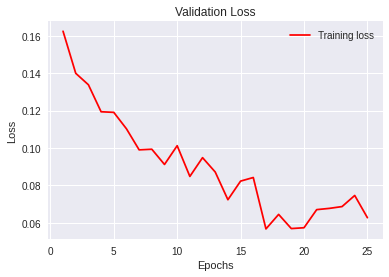

In [ ]:
%matplotlib inline


loss = history_dict['loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'r-', label='Training loss')

plt.title('Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

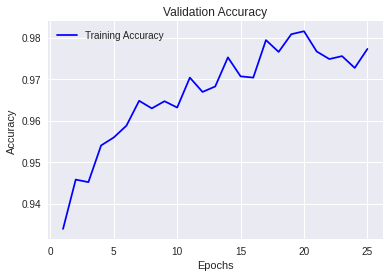

In [ ]:
%matplotlib inline


acc = history_dict['accuracy']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'b', label='Training Accuracy')

plt.title('Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [ ]:
# plt.style.available

In [ ]:
# %matplotlib inline

# plt.style.use('classic')

# loss = history_dict['loss']
# acc = history_dict['accuracy']

# epochs = range(1, len(loss) + 1)

# plt.plot(epochs, acc, 'b', label='Training Accuracy')
# plt.plot(epochs, loss, 'r', label='Training Loss')

# plt.title('Training Loss')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.legend()

# plt.show()

In [ ]:
from sklearn.metrics import RocCurveDisplay

In [ ]:
filtered_dataset_X = encode(filtered_df['Sequence'].values)
antigens = np.array(filtered_dataset_X)


Y_pred = model.predict(antigens)
Y_pred_P = (Y_pred > 0.6)

RocCurveDisplay(Y_pred,Y_pred_P)

22/22 [==============================] - 0s 5ms/step


TypeError: RocCurveDisplay.__init__() takes 1 positional argument but 3 were given

Ignore the 0s, 1 is Antigen Candidate


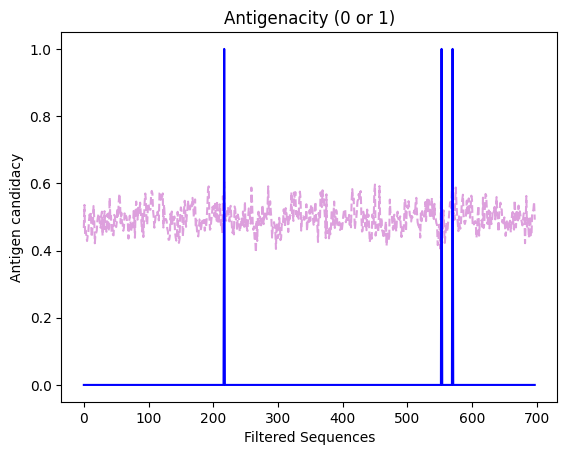

In [ ]:
print("Ignore the 0s, 1 is Antigen Candidate")

plt.plot(Y_pred, '--', color="plum")
plt.plot(Y_pred_P, color="blue")
plt.title("Antigenacity (0 or 1)")
plt.xlabel('Filtered Sequences')
plt.ylabel('Antigen candidacy')
plt.show()

In [ ]:
Y_pred.shape

(698, 1)

In [ ]:
filtered_df['antigenicity'] = Y_pred

<ipython-input-138-37c694635a9c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['antigenicity'] = Y_pred


In [ ]:
filtered_df.head()

,Sequence,Repeation,Seen In,antigenicity
124,RMAILGDTAW,6008,"DENGUE VIRUS 2, DENGUE VIRUS 4, DENGUE VIRUS 1...",0.000516
125,MAILGDTAWD,6025,"DENGUE VIRUS 2, DENGUE VIRUS 4, DENGUE VIRUS 1...",0.010988
126,AILGDTAWDF,6031,"DENGUE VIRUS 2, DENGUE VIRUS 4, DENGUE VIRUS 1...",0.000123
127,ILGDTAWDFG,6063,"DENGUE VIRUS 2, DENGUE VIRUS 4, DENGUE VIRUS 1...",0.000240
128,LGDTAWDFGS,6077,"DENGUE VIRUS 2, DENGUE VIRUS 4, DENGUE VIRUS 1...",0.086677


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
filtered_df.to_csv("[filtered][prediction]100% seq chunk-10.csv", index=False, )

In [ ]:
model_plotting = tf.keras.Sequential([
    bi_lstm,
    d_1,
    d_2,
    d_3
])

plot_pred = model_plotting.predict(antigens)

plot_pred[0:2]

22/22 [==============================] - 3s 56ms/step


array([[-13.895097 ,  -9.185564 , -22.840826 ],
       [ -6.2969003,  -3.7035482, -13.73841  ]], dtype=float32)

In [ ]:
from matplotlib import cm
cmap_d = cm._gen_cmap_d()

print(cmap_d.keys())

dict_keys(['magma', 'inferno', 'plasma', 'viridis', 'cividis', 'twilight', 'twilight_shifted', 'Blues', 'BrBG', 'BuGn', 'BuPu', 'CMRmap', 'GnBu', 'Greens', 'Greys', 'OrRd', 'Oranges', 'PRGn', 'PiYG', 'PuBu', 'PuBuGn', 'PuOr', 'PuRd', 'Purples', 'RdBu', 'RdGy', 'RdPu', 'RdYlBu', 'RdYlGn', 'Reds', 'Spectral', 'Wistia', 'YlGn', 'YlGnBu', 'YlOrBr', 'YlOrRd', 'afmhot', 'autumn', 'binary', 'bone', 'brg', 'bwr', 'cool', 'coolwarm', 'copper', 'cubehelix', 'flag', 'gist_earth', 'gist_gray', 'gist_heat', 'gist_ncar', 'gist_rainbow', 'gist_stern', 'gist_yarg', 'gnuplot', 'gnuplot2', 'gray', 'hot', 'hsv', 'jet', 'nipy_spectral', 'ocean', 'pink', 'prism', 'rainbow', 'seismic', 'spring', 'summer', 'terrain', 'winter', 'Accent', 'Dark2', 'Paired', 'Pastel1', 'Pastel2', 'Set1', 'Set2', 'Set3', 'tab10', 'tab20', 'tab20b', 'tab20c', 'magma_r', 'inferno_r', 'plasma_r', 'viridis_r', 'cividis_r', 'twilight_r', 'twilight_shifted_r', 'Blues_r', 'BrBG_r', 'BuGn_r', 'BuPu_r', 'CMRmap_r', 'GnBu_r', 'Greens_r', 

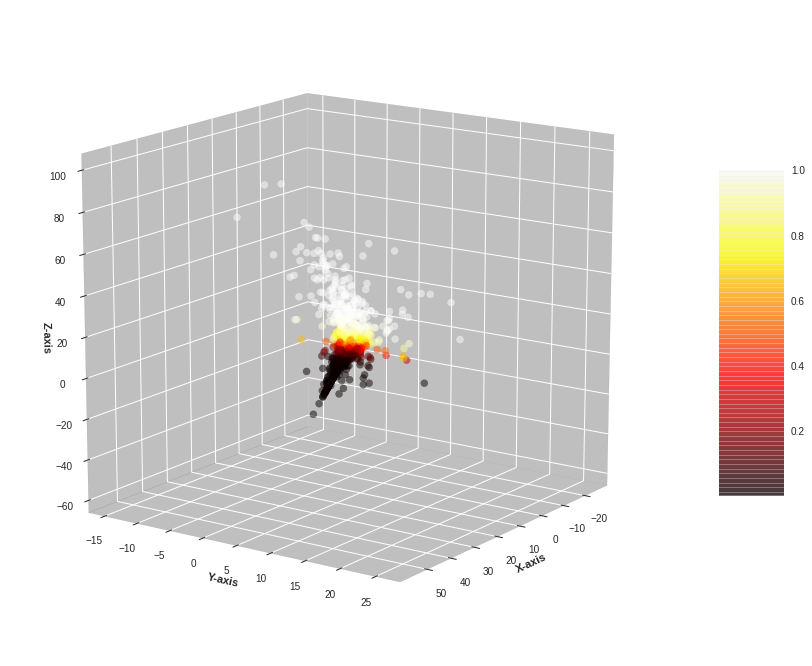

In [ ]:
import matplotlib as mpl
x, y, z = plot_pred[:, 0], plot_pred[:, 1], plot_pred[:, 2]

# Black Style
# plt.style.use('dark_background')
plt.style.use('seaborn')

# Creating figure
fig = plt.figure(figsize = (15, 12))
ax = plt.axes(projection ="3d")


fig.patch.set_facecolor('white')
fig.patch.set_alpha(0.0)

ax.patch.set_facecolor('white')
ax.patch.set_alpha(0.0)

color = (0.5, 0.5, 0.5, 0.5)

ax.w_xaxis.set_pane_color(color)
ax.w_yaxis.set_pane_color(color)
ax.w_zaxis.set_pane_color(color)

# Creating color map
my_cmap = cmap_d['hot']
# my_cmap = cmap_d['afmhot']
# my_cmap = cmap_d['Spectral']
# my_cmap = cmap_d['coolwarm']


# Creating plot
scat = ax.scatter3D(x, y, z, c=Y_pred, alpha = 0.5, s=50, cmap=my_cmap)

ax.set_xlabel('X-axis', fontweight ='bold')
ax.set_ylabel('Y-axis', fontweight ='bold')
ax.set_zlabel('Z-axis', fontweight ='bold')
ax.view_init(15, 35)
fig.colorbar(scat, ax = ax, shrink = 0.5, aspect = 5)

# show plot
plt.show()

In [ ]:
# plt.style.available
cmap_d

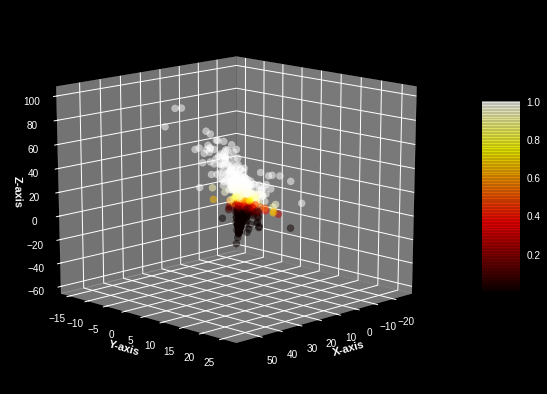

In [ ]:
x, y, z = plot_pred[:, 0], plot_pred[:, 1], plot_pred[:, 2]

# Black Style
plt.style.use('dark_background')

# Creating figure
fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")

# Creating color map
my_cmap = cmap_d['hot']
# my_cmap = cmap_d['afmhot']
# my_cmap = cmap_d['Spectral']

# Creating plot
scat = ax.scatter3D(x, y, z, c=Y_pred, alpha = 0.5, s=50, cmap=my_cmap)

ax.set_xlabel('X-axis', fontweight ='bold')
ax.set_ylabel('Y-axis', fontweight ='bold')
ax.set_zlabel('Z-axis', fontweight ='bold')
ax.view_init(15, 45)
fig.colorbar(scat, ax = ax, shrink = 0.5, aspect = 5)

# show plot
plt.show()

In [ ]:
from matplotlib import animation

def init():
    scat = ax.scatter3D(x, y, z, c=Y_pred, alpha = 0.5, s=50, cmap=my_cmap)
    return fig,

def animate(i):
    ax.view_init(elev=15., azim=i)
    return fig,


# Animate
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=360, interval=20, blit=True)


anim.save('basic_animation.mp4', fps=30, extra_args=['-vcodec', 'libx264'])

CalledProcessError: ignored

In [ ]:
from IPython.display import HTML
from base64 import b64encode

def show_video(video_path, video_width = 600):

  video_file = open(video_path, "r+b").read()

  video_url = f"data:video/mp4;base64,{b64encode(video_file).decode()}"
  return HTML(f"""<video width={video_width} controls><source src="{video_url}"></video>""")

show_video('basic_animation.mp4')

In [ ]:
model_attn = tf.keras.Sequential([
    bi_lstm,
    d_1,
    d_2,
    d_3
])

plot_pred = model_attn.predict(antigens)


22/22 [==============================] - 43s 21ms/step


In [ ]:
attn = antigens[0] @ plot_pred[0]

In [ ]:
attn.shape

(10,)

In [ ]:
attn

array([  15.40694145,   46.44363194,   12.86269467,  100.6520281 ,
         90.06559598,   11.39630963, -114.86218908,   38.39149626,
         12.86269467,   13.05969882])

In [ ]:
def add_margin(ax,x=0.05,y=0.05):
    # This will, by default, add 5% to the x and y margins. You
    # can customise this using the x and y arguments when you call it.

    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    xmargin = (xlim[1]-xlim[0])*x
    ymargin = (ylim[1]-ylim[0])*y

    ax.set_xlim(xlim[0]-xmargin,xlim[1]+xmargin)
    ax.set_ylim(ylim[0]-ymargin,ylim[1]+ymargin)

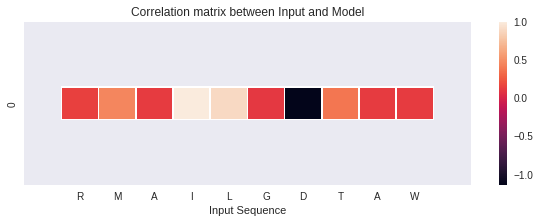

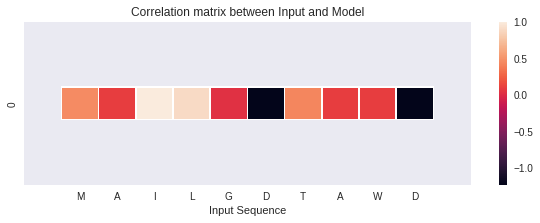

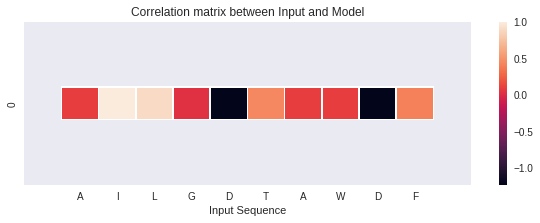

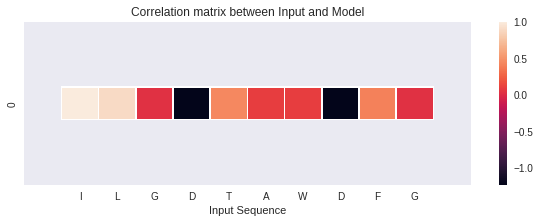

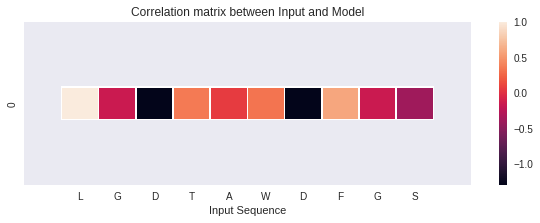

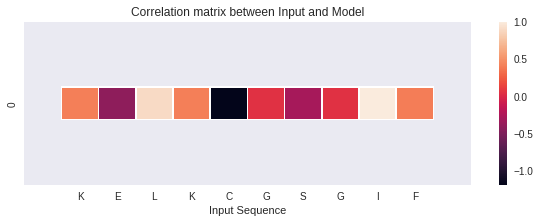

In [ ]:
# Smoothing
from scipy.ndimage.filters import gaussian_filter

def fill_par(x):
    ma = max(x)
    mi = min(x)
    return x / ma

for i in range(0, 6):
    fig, ax = plt.subplots(figsize = (10, 3))

    # Data
    attn = fill_par(antigens[i] @ plot_pred[i])
    data = np.asarray([attn])
    data_smooth = gaussian_filter(data, sigma=1)

    # Plot
    # ax_ = sns.heatmap(data_smooth, linewidths=.5, ax=ax)
    ax_ = sns.heatmap(data, linewidths=.5, ax=ax)
    ax_.set_xlabel('Input Sequence')
    # ax_.set_ylabel('Attention')
    ax_.set_xticklabels(list(unZ(antigens[i])))

    add_margin(ax_, 0.1, 2)

    plt.title("Correlation matrix between Input and Model")

    plt.show()